# Denoising Diffusion Implicit Models-based Synthetic Medical Image Augmentation for increased CNN Performance in COVID-19 Classification

**Author:** Simone Rossetti<br>
**Date created:** 2023/01/02<br>
**Last modified:** 2023/01/02<br>
**Description:** Generating augmented images of COVID-19 chest X-rays with denoising diffusion implicit models for downstram tasks improvement.

**Inspired by:** https://keras.io/examples/generative/ddim/



## Introduction

### What are diffusion models?

Recently, [denoising diffusion models](https://arxiv.org/abs/2006.11239), including
[score-based generative models](https://arxiv.org/abs/1907.05600), gained popularity as a
powerful class of generative models, that can [rival](https://arxiv.org/abs/2105.05233)
even [generative adversarial networks (GANs)](https://arxiv.org/abs/1406.2661) in image
synthesis quality. They tend to generate more diverse samples, while being stable to
train and easy to scale. Recent large diffusion models, such as
[DALL-E 2](https://openai.com/dall-e-2/) and [Imagen](https://imagen.research.google/),
have shown incredible text-to-image generation capability. One of their drawbacks is
however, that they are slower to sample from, because they require multiple forward passes
for generating an image.

Diffusion refers to the process of turning a structured signal (an image) into noise
step-by-step. By simulating diffusion, we can generate noisy images from our training
images, and can train a neural network to try to denoise them. Using the trained network
we can simulate the opposite of diffusion, reverse diffusion, which is the process of an
image emerging from noise.

<!--![diffusion process gif](https://i.imgur.com/dipPOfa.gif)-->

One-sentence summary: **diffusion models are trained to denoise noisy images, and can
generate images by iteratively denoising pure noise.**
<!--
### Goal of this example

This code example intends to be a minimal but feature-complete (with a generation quality
metric) implementation of diffusion models, with modest compute requirements and
reasonable performance. My implementation choices and hyperparameter tuning were done
with these goals in mind.

Since currently the literature of diffusion models is
[mathematically quite complex](https://arxiv.org/abs/2206.00364)
with multiple theoretical frameworks
([score matching](https://arxiv.org/abs/1907.05600),
[differential equations](https://arxiv.org/abs/2011.13456),
[Markov chains](https://arxiv.org/abs/2006.11239)) and sometimes even
[conflicting notations (see Appendix C.2)](https://arxiv.org/abs/2010.02502),
it can be daunting trying to understand
them. My view of these models in this example will be that they learn to separate a
noisy image into its image and Gaussian noise components.

In this example I made effort to break down all long mathematical expressions into
digestible pieces and gave all variables explanatory names. I also included numerous
links to relevant literature to help interested readers dive deeper into the topic, in
the hope that this code example will become a good starting point for practitioners
learning about diffusion models.
-->
In the following sections, we will implement a continous time version of
[Denoising Diffusion Implicit Models (DDIMs)](https://arxiv.org/abs/2010.02502)
with deterministic sampling.

## Setup

In [2]:
! pip install tensorflow_addons

In [1]:
import os
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

2023-01-05 12:56:50.290140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 12:56:50.467230: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Hyperparameterers

In [2]:
# data
dataset_repetitions = 40
num_epochs = 50
image_size = 64

# KID = Kernel Inception Distance, see related section
kid_image_size = 75
kid_diffusion_steps = 10
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2
num_last_channels = 1 # 1=grayscale, 3=rgb

# optimization
batch_size = 64
val_batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

## Data pipeline

We will use an older version of the [COVID-19 Chest Xray Dataset](https://github.com/ieee8023/covid-chestxray-dataset) dataset, used previously in [Transfer learning COVID-19](https://github.com/vj2050/Transfer-Learning-COVID-19) and [GAN-based Synthetic Medical Image Augmentation for increased CNN Performance in COVID-19 Classification](https://github.com/rossettisimone/AUGMENTATION_GAN.git), which is a xray scans pneumonia disease dataset of 306 images. The dataset is well structured and contains 4 classes namely, *covid*, *normal*, *pneumonia bacteria* and *pneumonia viral*. The dataset has a total of 270 training images (60,70,70,70) and 36 test images (9,9,9,9). We used the default train/test split proposed by the creators of the dataset. We run our training over a fixed classically augmented dataset (affine transformations and color jittering) from [GAN-based Synthetic Medical Image Augmentation for increased CNN Performance in COVID-19 Classification](https://github.com/rossettisimone/AUGMENTATION_GAN.git).

In [ ]:
! git clone https://github.com/rossettisimone/AUGMENTATION_GAN.git

In [3]:
# data
CATEGORIES = ["covid", "normal", "pneumonia_bac", "pneumonia_vir"]
dataset_name = CATEGORIES[0]
source_dir = 'AUGMENTATION_GAN/custom_covid_dataset'
dest_dir = 'AUGMENTATION_DDIM'
# we create destination folders to store the checkpoints and logs
model_dir = os.path.join(dest_dir,'ddim_models')
log_dir = os.path.join(dest_dir,'ddim_logs')
os.makedirs(dest_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [4]:
def preprocess_image(data):
    # we take the augmented dataset as it is
    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(data, size=[image_size, image_size], antialias=True)
    if num_last_channels == 1: 
        image = tf.image.rgb_to_grayscale(image)
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)

def prepare_dataset(split, dataset_name, batch_size):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    def image_dataset(split_item):
      return tf.keras.utils.image_dataset_from_directory(
                  os.path.join(source_dir,split_item,dataset_name),
                  seed=123,
                  shuffle=True,
                  label_mode=None,
                  batch_size=None)
    # concatenate multiple k-folds of the dataset
    if isinstance(split,list):
      dataset = image_dataset(split[0])
      for s in split[1:]:
        dataset = dataset.concatenate(image_dataset(s))
    elif isinstance(split,str):
      dataset = image_dataset(split)
    else:
      raise ValueError('*split* must be str or list type')
    return ( 
            dataset
            .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
            .cache()
            .repeat(dataset_repetitions)
            .shuffle(10 * batch_size)
            .batch(batch_size, drop_remainder=True)
            .prefetch(buffer_size=tf.data.AUTOTUNE)
          )


# load dataset
train_dataset = prepare_dataset(
  [
    "train",
    "train_classic/500",
    "train_classic/1000",
    "train_classic/2000",
  ],
  dataset_name, batch_size)
val_dataset = prepare_dataset("test",dataset_name,val_batch_size)

Found 60 files belonging to 1 classes.


2023-01-05 12:57:00.655026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 12:57:01.466938: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46708 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-01-05 12:57:01.467495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46708 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:61:00.0, compute capability: 8.6


Found 500 files belonging to 1 classes.
Found 500 files belonging to 1 classes.
Found 1000 files belonging to 1 classes.
Found 9 files belonging to 1 classes.


2023-01-05 12:57:15.245613: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


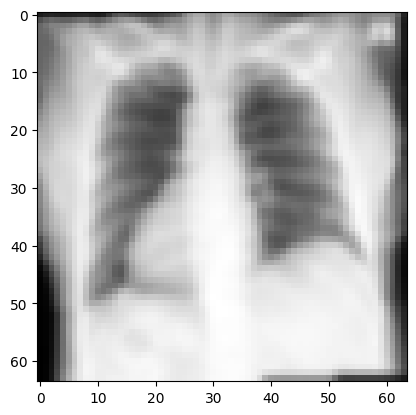

In [5]:
# show an example
import matplotlib.pyplot as plt
plt.imshow(next(iter(train_dataset))[0])
plt.gray()

## Kernel inception distance

[Kernel Inception Distance (KID)](https://arxiv.org/abs/1801.01401) is an image quality
metric which was proposed as a replacement for the popular
[Frechet Inception Distance (FID)](https://arxiv.org/abs/1706.08500).
KID can be estimated per-batch, and is computationally lighter than FID. More details
[here](https://keras.io/examples/generative/gan_ada/#kernel-inception-distance).

Images are evaluated at the minimal possible resolution of the
Inception network (75x75 instead of 299x299), and the metric is only measured on the
validation set for computational efficiency. We also limit the number of sampling steps
at evaluation to 10 for the same reason.

Since the dataset is relatively small, we go over the train and validation splits
multiple times per epoch, because the KID estimation is noisy and compute-intensive, so
we want to evaluate only after many iterations, but for many iterations.

In [6]:

class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, num_last_channels)),
                layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x) if num_last_channels == 1 else x),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()


## Network architecture

Here we specify the architecture of the neural network that we will use for denoising. We
build a [U-Net](https://arxiv.org/abs/1505.04597) with identical input and output
dimensions. U-Net is a popular semantic segmentation architecture, whose main idea is
that it progressively downsamples and then upsamples its input image, and adds skip
connections between layers having the same resolution. These help with gradient flow and
avoid introducing a representation bottleneck, unlike usual
[autoencoders](https://www.deeplearningbook.org/contents/autoencoders.html). Based on
this, one can view
[diffusion models as denoising autoencoders](https://benanne.github.io/2022/01/31/diffusion.html)
without a bottleneck.

The network takes two inputs, the noisy images and the variances of their noise
components. The latter is required since denoising a signal requires different operations
at different levels of noise. We transform the noise variances using sinusoidal
embeddings, similarly to positional encodings used both in
[transformers](https://arxiv.org/abs/1706.03762) and
[NeRF](https://arxiv.org/abs/2003.08934). This helps the network to be
[highly sensitive](https://arxiv.org/abs/2006.10739) to the noise level, which is
crucial for good performance. We implement sinusoidal embeddings using a
[Lambda layer](https://keras.io/api/layers/core_layers/lambda/).

Some other considerations:

* We build the network using the
[Keras Functional API](https://keras.io/guides/functional_api/), and use
[closures](https://twitter.com/fchollet/status/1441927912836321280) to build blocks of
layers in a consistent style.
* [Diffusion models](https://arxiv.org/abs/2006.11239) embed the index of the timestep of
the diffusion process instead of the noise variance, while
[score-based models (Table 1)](https://arxiv.org/abs/2206.00364)
usually use some function of the noise level. I
prefer the latter so that we can change the sampling schedule at inference time, without
retraining the network.
* [Diffusion models](https://arxiv.org/abs/2006.11239) input the embedding to each
convolution block separately. We only input it at the start of the network for
simplicity, which in my experience barely decreases preformance, because the skip and
residual connections help the information propagate through the network properly.
* In the literature it is common to use
[attention layers](https://keras.io/api/layers/attention_layers/multi_head_attention/)
at lower resolutions for better global coherence. I omitted it for simplicity.
* We disable the learnable center and scale parameters of the batch normalization layers,
since the following convolution layers make them redundant.
* We initialize the last convolution's kernel to all zeros as a good practice, making the
network predict only zeros after initialization, which is the mean of its targets. This
will improve behaviour at the start of training and make the mean squared error loss
start at exactly 1.

In [7]:
# diffusion step encoding (t)
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

# U-net

def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, num_last_channels))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e) #image_size

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(num_last_channels, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")


## Diffusion model

### Diffusion schedule

Let us say, that a diffusion process starts at time = 0, and ends at time = 1. This
variable will be called diffusion time, and can be either discrete (common in diffusion
models) or continuous (common in score-based models). I choose the latter, so that the
number of sampling steps can be changed at inference time.

We need to have a function that tells us at each point in the diffusion process the noise
levels and signal levels of the noisy image corresponding to the actual diffusion time.
This will be called the diffusion schedule (see `diffusion_schedule()`).

This schedule outputs two quantities: the `noise_rate` and the `signal_rate`
(corresponding to sqrt(1 - alpha) and sqrt(alpha) in the DDIM paper, respectively). We
generate the noisy image by weighting the random noise and the training image by their
corresponding rates and adding them together.

Since the (standard normal) random noises and the (normalized) images both have zero mean
and unit variance, the noise rate and signal rate can be interpreted as the standard
deviation of their components in the noisy image, while the squares of their rates can be
interpreted as their variance (or their power in the signal processing sense). The rates
will always be set so that their squared sum is 1, meaning that the noisy images will
always have unit variance, just like its unscaled components.

We will use a simplified, continuous version of the
[cosine schedule (Section 3.2)](https://arxiv.org/abs/2102.09672),
that is quite commonly used in the literature.
This schedule is symmetric, slow towards the start and end of the diffusion process, and
it also has a nice geometric interpretation, using the
[trigonometric properties of the unit circle](https://en.wikipedia.org/wiki/Unit_circle#/media/File:Circle-trig6.svg):

![diffusion schedule gif](https://i.imgur.com/JW9W0fA.gif)

### Training process

The training procedure (see `train_step()` and `denoise()`) of denoising diffusion models
is the following: we sample random diffusion times uniformly, and mix the training images
with random gaussian noises at rates corresponding to the diffusion times. Then, we train
the model to separate the noisy image to its two components.

Usually, the neural network is trained to predict the unscaled noise component, from
which the predicted image component can be calculated using the signal and noise rates.
We use pixelwise
[mean squared error](https://keras.io/api/losses/regression_losses/#mean_squared_error-function).

### Sampling (reverse diffusion)

When sampling (see `reverse_diffusion()`), at each step we take the previous estimate of
the noisy image and separate it into image and noise using our network. Then we recombine
these components using the signal and noise rate of the following step.

Though a similar view is shown in
[Equation 12 of DDIMs](https://arxiv.org/abs/2010.02502), I believe the above explanation
of the sampling equation is not widely known.

This example implements the deterministic sampling procedure from DDIM when `reverse_diffusion(deterministic=True)`, which
corresponds to *sigma = 0* in the paper. When `reverse_diffusion(deterministic=False)` one can also use stochastic sampling (in which
case the model becomes a
[Denoising Diffusion Probabilistic Model (DDPM)](https://arxiv.org/abs/2006.11239)),
where a part of the predicted noise is
replaced with the same or larger amount of random noise
([see Equation 16 and below](https://arxiv.org/abs/2010.02502)).

Stochastic sampling can be used without retraining the network (since both models are
trained the same way), and it can improve sample quality, while on the other hand
requiring more sampling steps usually.

In [21]:
from tensorflow.python.types.core import Value

class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    def call(self, images):
        pass

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps, inpaint_image=None, inpaint_mask=None, deterministic=True, return_path=False):
        # when inpaint_image and inpaint_mask are tensors performs inpainting
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise

        path = [next_noisy_images] # return the entire sequence if needed

        for step in range(diffusion_steps):
            noisy_images = next_noisy_images


            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size

            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size

            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )

            if deterministic:
                next_noisy_images_func = lambda x: (
                    next_signal_rates * x + next_noise_rates * pred_noises
                )
            else:
                sigma = (next_noise_rates**2 / noise_rates**2)**0.5 * (1. - signal_rates**2 / next_signal_rates**2)**0.5
                next_noisy_images_func = lambda x: (
                    next_signal_rates * x + (next_noise_rates**2 - sigma**2)**0.5 * pred_noises + sigma * tf.random.normal(tf.shape(x))
                )
            
            next_noisy_images = next_noisy_images_func(pred_images)
            # this new noisy image will be used in the next step
            
            if tf.is_tensor(inpaint_mask) and tf.is_tensor(inpaint_image):
                next_noisy_images = tf.where(inpaint_mask, next_noisy_images_func(inpaint_image), next_noisy_images)

            path.append(next_noisy_images)
        
        path.append(pred_images)
        if return_path: return path
        
        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, num_last_channels))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def spherical_interpolation(self, noise1, noise2, lamb):  

        def fro_norm(tensor,axis,keepdims):
            return tf.math.square(tf.reduce_sum(tf.abs(tensor)**2,axis=axis,keepdims=keepdims))

        theta = tf.math.acos(tf.reduce_sum(noise1 * noise2, axis=(1,2,3),keepdims=True) / (fro_norm(noise1,(1,2,3),True) * fro_norm(noise2,(1,2,3),True)))
        return (
            tf.math.sin((1 - lamb) * theta) / tf.math.sin(theta) * noise1
            + tf.math.sin(lamb * theta) / tf.math.sin(theta) * noise2
        )

    def interpolate(self, num_images=None, diffusion_steps=40, deterministic=True, lamb=0.5):
        # perform interpolation in latent space
        if not isinstance(num_images, int):
            raise ValueError('num_images must be integer')

        noise1 = tf.random.normal(shape=(num_images, image_size, image_size, num_last_channels))
        images1 = self.reverse_diffusion(noise1, diffusion_steps, deterministic=deterministic)

        noise2 = tf.random.normal(shape=tf.shape(images1))
        images2 = self.reverse_diffusion(noise2, diffusion_steps, deterministic=deterministic)

        if isinstance(lamb,float):
            noiselamb = self.spherical_interpolation(noise1, noise2, lamb)
            imageslamb = self.reverse_diffusion(noiselamb, diffusion_steps, deterministic=deterministic)
        elif isinstance(lamb,list):
            imageslamb = []
            for lam in lamb:
                imageslamb.append(self.reverse_diffusion(self.spherical_interpolation(noise1, noise2, lam), diffusion_steps, deterministic=deterministic))
            imageslamb = tf.stack(imageslamb,axis=0)
        else:
          raise ValueError('lamb should be float or list')

        return images1, images2, imageslamb

    def inpaint(self, inpaint_image, inpaint_mask, diffusion_steps=50, initial_noise=None, deterministic=True):
        # perform inpainting
        if not tf.is_tensor(initial_noise):
            initial_noise = tf.random.normal(shape=tf.shape(inpaint_image))
        return self.reverse_diffusion(initial_noise, diffusion_steps, inpaint_image, inpaint_mask, deterministic)

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        batch_size = tf.shape(images)[0]
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, num_last_channels))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        batch_size = tf.shape(images)[0]
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, num_last_channels))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps
        )
        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # plot random generated images for visual evaluation of generation quality
        generated_images = tf.squeeze(self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        ),axis=-1)

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.gray()
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()


## Training

In [23]:
# create and compile the model
model = DiffusionModel(image_size, widths, block_depth)

model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_squared_error,
)
# pixelwise mean squared error is used as loss
categ_dir = os.path.join(model_dir, dataset_name)
os.makedirs(categ_dir, exist_ok=True)
# save the best model based on the validation KID metric
checkpoint_path = os.path.join(categ_dir, 'weights-{epoch:02d}-{val_kid:.4f}.tf')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

logs_dir = os.path.join(log_dir, dataset_name)
os.makedirs(logs_dir, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logs_dir,
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None,
)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)
# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[
        tensorboard_callback,
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

# Inference

AUGMENTATION_DDIM/ddim_models/covid/weights-05-1.5110.tf
Model: "diffusion_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  multiple                 3         
 ion)                                                            
                                                                 
 residual_unet (Functional)  (None, 64, 64, 1)         1953377   
                                                                 
 residual_unet (Functional)  (None, 64, 64, 1)         1953377   
                                                                 
Total params: 3,906,763
Trainable params: 3,900,994
Non-trainable params: 5,769
_________________________________________________________________


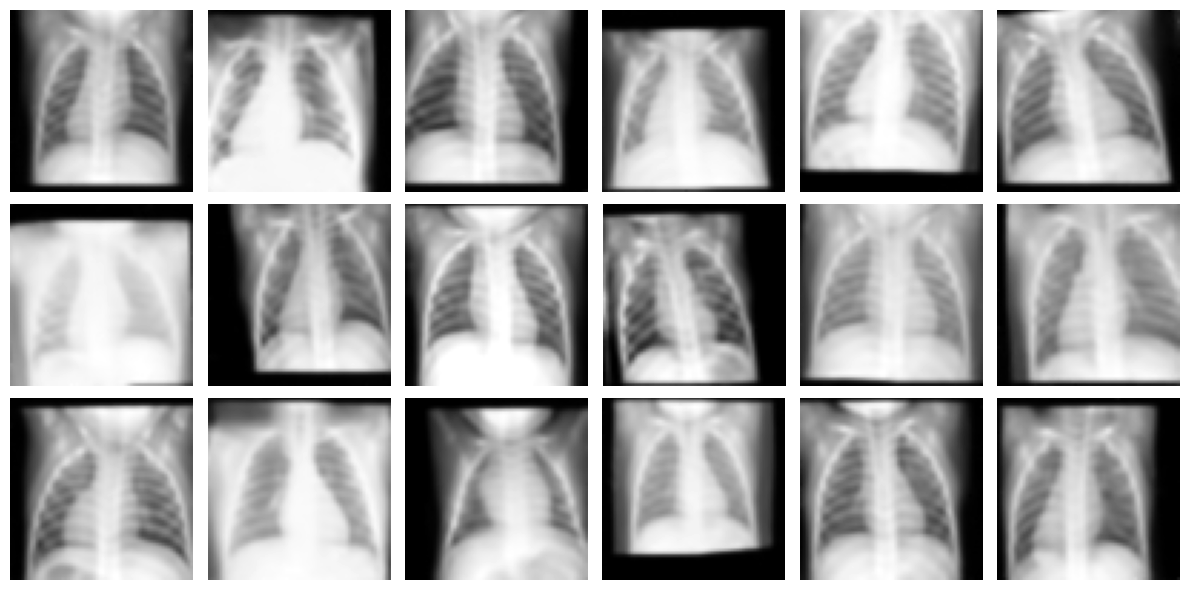

In [33]:
# create model
model.build(input_shape=(None,))

# load trained weights
checkpoint_path = os.path.join(model_dir, dataset_name)
latest = tf.train.latest_checkpoint(checkpoint_path)
print(latest)
model.load_weights('drive/MyDrive/AUGMENTATION_DDIM/ddim_models/normal/weights-32-5.0655.tf')#(latest)
model.summary()
model.plot_images()

## Diffusion view

In [36]:
initial_noise = tf.random.normal(shape=(1, image_size, image_size, num_last_channels))
generated_images = model.reverse_diffusion(initial_noise, 80, return_path=True)
generated_images = [tf.squeeze(model.denormalize(im)) for im in generated_images]
final_image = tf.squeeze(generated_images[-1])
initial_noise = tf.squeeze(initial_noise)

filenames = []
for i,im in enumerate([initial_noise]+generated_images+[final_image]):
    plt.gray()
    fig, axs = plt.subplots(1,3, figsize=(3 * 3.0, 1 * 3.0))
    # plot the line chart
    axs[0].imshow(final_image)
    axs[0].axis('off')
    axs[1].imshow(im)
    axs[1].axis('off')
    axs[2].imshow(initial_noise)
    axs[2].axis('off')

    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()

import imageio
# build gif
with imageio.get_writer('mygif.gif', mode='I', fps=60) as writer:
    for filename in filenames+filenames[::-1]:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

/tmp/ipykernel_462/1805706146.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


<Figure size 640x480 with 0 Axes>

# Inpainting

In [ ]:
def random_uniform_choice(inputs, n_samples=1):
    '''
    # Web source
    With replacement.
    Params:
      inputs (Tensor): Shape [n_states, n_features]
      n_samples (int): The number of random samples to take.
    Returns:
      sampled_inputs (Tensor): Shape [n_samples, n_features]
    '''
    uniform_log_prob = tf.expand_dims(tf.zeros(tf.shape(inputs)[0]), 0)
    ind = tf.random.categorical(uniform_log_prob, n_samples)
    ind = tf.squeeze(ind, 0, name="random_uniform_choice_ind")
    return tf.gather(inputs, ind, name="random_uniform_choice")

def bbox_for_crop(image_size: int=64 , max_bbox: int = 50, min_bbox: int = 10):
    '''
    We use top-left/right-bottom 
    convention for bounding boxes:
    (x1,y1) +-------+
            |       |
            |       |
            +-------+
                    (x2,y2)
    '''    
    deltas_options = tf.range(min_bbox,max_bbox+1,dtype=tf.int32)
    deltas = tf.convert_to_tensor(random_uniform_choice(deltas_options,n_samples=1), deltas_options.dtype)
    start_options = tf.range(0,image_size-deltas,dtype=tf.int32)
    start = tf.minimum(random_uniform_choice(start_options,n_samples=2), image_size-deltas)
    bbox = tf.concat([start, start + deltas], -1) 
    return tf.cast(bbox,tf.int32)

def bbox_for_crop_batch(batch_size: int = 1, image_size: int = 64, max_bbox: int = 50, min_bbox: int = 10):
    ''' apply affine transformations to a batch '''
    def tile_int(number):
        return tf.tile(tf.convert_to_tensor(number)[None],(batch_size,))
    return tf.map_fn(
        lambda inputs: bbox_for_crop(*inputs),
        [tile_int(image_size),tile_int(max_bbox),tile_int(min_bbox)],
        fn_output_signature=tf.int32
        )

def random_binary_mask_images(images, max_bbox, min_bbox):
    # create a random binary mask with cropped bbox
    b, h, w, c = tf.shape(images)
    xx, yy = tf.meshgrid(tf.range(0,w), tf.range(0,h))
    xx, yy = tf.tile(xx[None,...,None],(b,1,1,1)), tf.tile(yy[None,...,None],(b,1,1,1))
    bboxes = tf.tile(bbox_for_crop_batch(b, h, max_bbox, min_bbox)[:,None,None],(1,h,w,1))
    masks = (xx < bboxes[...,0:1]) | (xx > bboxes[...,2:3]) | (yy < bboxes[...,1:2]) | (yy > bboxes[...,3:4])
    return masks


In [ ]:
import matplotlib.pyplot as plt
num_images = 5
num_cols = 3
# noise -> images -> denormalized images
images = next(iter(train_dataset))[:num_images]
masks = random_binary_mask_images(images,45,20)
masks = tf.where(tf.random.uniform(tf.shape(masks)[:1])[...,None,None,None]>0.7,masks,tf.logical_not(masks))
generated_images = model.inpaint(inpaint_image=model.normalizer(images,training=False), inpaint_mask=masks, diffusion_steps=50, deterministic=False)
generated_images = tf.squeeze(model.denormalize(generated_images),-1)
fig, axs = plt.subplots(num_images, num_cols, figsize=(num_cols * 4.0, num_images * 4.0))
for i in range(num_images):
    axs[i,0].imshow(images[i])
    axs[i,1].imshow(images[i]*tf.cast(masks[i],images.dtype))
    axs[i,2].imshow(generated_images[i])
    plt.gray()
    axs[i,0].get_xaxis().set_ticks([])
    axs[i,0].get_yaxis().set_ticks([])
    axs[i,1].get_xaxis().set_ticks([])
    axs[i,1].get_yaxis().set_ticks([])
    axs[i,2].get_xaxis().set_ticks([])
    axs[i,2].get_yaxis().set_ticks([])
    if i == num_images-1:
        axs[i,0].set_xlabel('input')
        axs[i,1].set_xlabel('masked')
        axs[i,2].set_xlabel('inpaint')
        axs[i,0].xaxis.label.set_fontsize(24)
        axs[i,1].xaxis.label.set_fontsize(24)
        axs[i,2].xaxis.label.set_fontsize(24)
fig.tight_layout()
plt.show()
plt.close()

# Interpolation in latent space

In [ ]:
import matplotlib.pyplot as plt
num_images = 5
lambs = [i/10 for i in range(0,11,1)]
generated_images = model.interpolate(num_images=num_images, diffusion_steps=50, deterministic=True, lamb=lambs)
fig, axs = plt.subplots(num_images, len(lambs), figsize=(len(lambs) * 4.0, num_images * 4.0))
generated_images = model.denormalize(generated_images[2])
for i in range(num_images):
    for j in range(len(lambs)):
        axs[i,j].imshow(generated_images[j,i,...,0])
        axs[i,j].get_xaxis().set_ticks([])
        axs[i,j].get_yaxis().set_ticks([])
        if i == num_images-1:
            axs[i,j].set_xlabel(r'$\lambda$= ' + str(lambs[j]))
            axs[i,j].xaxis.label.set_fontsize(24)
        plt.gray()
fig.tight_layout()
plt.show()
plt.close()

# Build DDIM synthetic augmented dataset

In [ ]:
from PIL import Image
import numpy as np
from tqdm import tqdm
data_dir = os.path.join(dest_dir,'custom_covid_dataset','train_synthetic_ddim')
os.makedirs(data_dir, exist_ok=True)
for s in [100,500,1000,2000]: os.makedirs(os.path.join(data_dir,str(s)), exist_ok=True);
for s in [100,500,1000,2000]: 
  for d in CATEGORIES: os.makedirs(os.path.join(data_dir,str(s),d), exist_ok=True);
  
size = [100,500,1000,2000]
batches = [100,400,500,1000]
for i, batch in enumerate(batches):
    images = tf.image.grayscale_to_rgb(model.generate(batch,diffusion_steps=100))
    for j,im in enumerate(images):
        save_path = os.path.join(data_dir,str(size[i]),dataset_name,'image_{0:04d}.png'.format(j))
        im=Image.fromarray((255*im.numpy()).astype(np.uint8))
        im.save(save_path)
